In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import pandas as pd
from tqdm import tqdm, trange

INPUT_PATH = '/kaggle/input/smartphone-decimeter-2023/sdc2023/'

df_sample_trail_gnss = pd.read_csv(INPUT_PATH + "train/2020-06-25-00-34-us-ca-mtv-sb-101/pixel4/device_gnss.csv")
df_sample_trail_gt = pd.read_csv(INPUT_PATH + "train/2020-06-25-00-34-us-ca-mtv-sb-101/pixel4/ground_truth.csv")
sample_submission = pd.read_csv(INPUT_PATH + "sample_submission.csv")

In this challenge, our only output is a **longitude** and **latitude** for each millisecond-accurate timestep.
この課題では、ミリ秒精度のタイムステップごとに経度と緯度を出力するだけだ。


In [2]:
sample_submission.head()

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715055442,34.640195,-120.589642
1,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715056442,34.640195,-120.589642
2,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715057442,34.640195,-120.589642
3,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715058442,34.640195,-120.589642
4,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715059442,34.640195,-120.589642


Recall that our training data has two components:
1. device_gnss (Noisy data from phone sensors)
2. ground_truth (high-quality, accurate data from laser rangefinders + dual-channel GPS sensors).

In our testing phase, we're only able to make predictions off of device_gnss data. Our goal is thus to predict the longitude and latitude of *ground_truth* given *device_gnss*.

Note that our input data and desired output data is both timeseries. As shown below, the device_gnss data spans the entire duration of a test drive (roughly 20 minutes). Our prediction target has the same duration as well (albeit starting one second later):

トレーニングデータには2つの要素がある：
1.device_gnss（電話センサーからのノイズの多いデータ）
2.ground_truth（レーザー距離計＋デュアルチャンネルGPSセンサーからの高品質で正確なデータ）。

テスト段階では、device_gnssのデータからしか予測はできない。したがって、私たちの目標は、*device_gnss*が与えられた*ground_truth*の経度と緯度を予測することです。

入力データと希望する出力データは両方とも時系列であることに注意してください。以下に示すように、device_gnssデータはテストドライブの全時間（およそ20分）にわたります。予測対象も同じ期間です（開始は1秒後ですが）：

In [3]:
# ユニックスタイムの変更
from datetime import datetime

def utc_to_human_readable(utcTime):
    utc_datetime_str = datetime.fromtimestamp(utcTime / 1e3)
    return datetime.strftime(utc_datetime_str, '%Y-%m-%d | %H:%M:%S')

print("Duration of input data (s):", 
      (df_sample_trail_gnss["utcTimeMillis"].max() - df_sample_trail_gnss["utcTimeMillis"].min()) * 1e-3)
print("Starting from", utc_to_human_readable(df_sample_trail_gnss["utcTimeMillis"].min()),
      "to", utc_to_human_readable(df_sample_trail_gnss["utcTimeMillis"].max()))
labels = df_sample_trail_gt[["LatitudeDegrees", "LongitudeDegrees", "UnixTimeMillis"]]
print("Duration of target data (s):", 
      (labels["UnixTimeMillis"].max() - labels["UnixTimeMillis"].min()) * 1e-3)
print("Starting from", utc_to_human_readable(labels["UnixTimeMillis"].min()),
      "to", utc_to_human_readable(labels["UnixTimeMillis"].max()))

Duration of input data (s): 1299.0
Starting from 2020-06-25 | 00:34:12 to 2020-06-25 | 00:55:51
Duration of target data (s): 1298.0
Starting from 2020-06-25 | 00:34:13 to 2020-06-25 | 00:55:51


The frequency at which we collect the data is once per second, or 1Hz. You might be wondering, then, why our input trajectory (gnss data) then has significantly more data points than this low frequency seems to suggest. This is due to the fact that we receive data from many satellites from different GPS constellations at every timestep:

Note that the Svid does not uniquely identify a satellite; distinct satellites between different constellations can have the same Svid. 

データを収集する頻度は1秒に1回、つまり1Hzである。では、なぜ入力軌道（gnssデータ）には、この低い周波数から想像されるよりもかなり多くのデータポイントがあるのか、不思議に思われるかもしれません。これは、タイムステップごとに異なるGPSコンステレーションの多くの衛星からデータを受信しているためです：

Svidは衛星を一意に識別するものではなく、異なる星座間の異なる衛星が同じSvidを持つことがあります。

In [4]:
print("Num input data timesteps:", len(df_sample_trail_gnss["utcTimeMillis"].unique()))
df_sample_trail_gnss[df_sample_trail_gnss["TimeNanos"] == 1047929361000000][["Svid", "State", "SvVelocityXEcefMetersPerSecond", "ConstellationType"]]

Num input data timesteps: 1300


,Svid,State,SvVelocityXEcefMetersPerSecond,ConstellationType
0,10,16399,1087.176543,1
1,13,16399,457.976994,1
2,15,16399,1089.489174,1
3,16,16399,-1601.141997,1
4,18,16399,1897.766597,1
5,20,16399,2247.992495,1
6,21,16399,1684.809007,1
7,26,16399,-143.180410,1
8,29,16399,291.933900,1
9,32,16399,-334.136257,1


Our ground truth data, fortunately, has just one row of data per timestep.

To recap:
- GNSS input, shape (timesteps, # satellite signals, data_dim). At each timestep, we receive data from a varying number of satellites.
- Target, shape (timesteps, 2) - Longitude and Latitude for each timestep.
- Ground truth, shape (timesteps, data_dim) - auxiliary data we can use in train time that is unavailable at test time.

私たちの真実のデータは、幸いなことに、タイムステップごとに1行しかない。

要約すると
- GNSS入力、形状（timesteps, #衛星信号, data_dim）。各タイムステップで、様々な数の衛星からデータを受信。
- ターゲット、形状 (timesteps, 2) - 各タイムステップの経度と緯度。
- Ground truth, shape (timesteps, data_dim) - 訓練時には使用できるが、テスト時には使用できない補助データ。

Let's take a look at the trends within our data:

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.optio

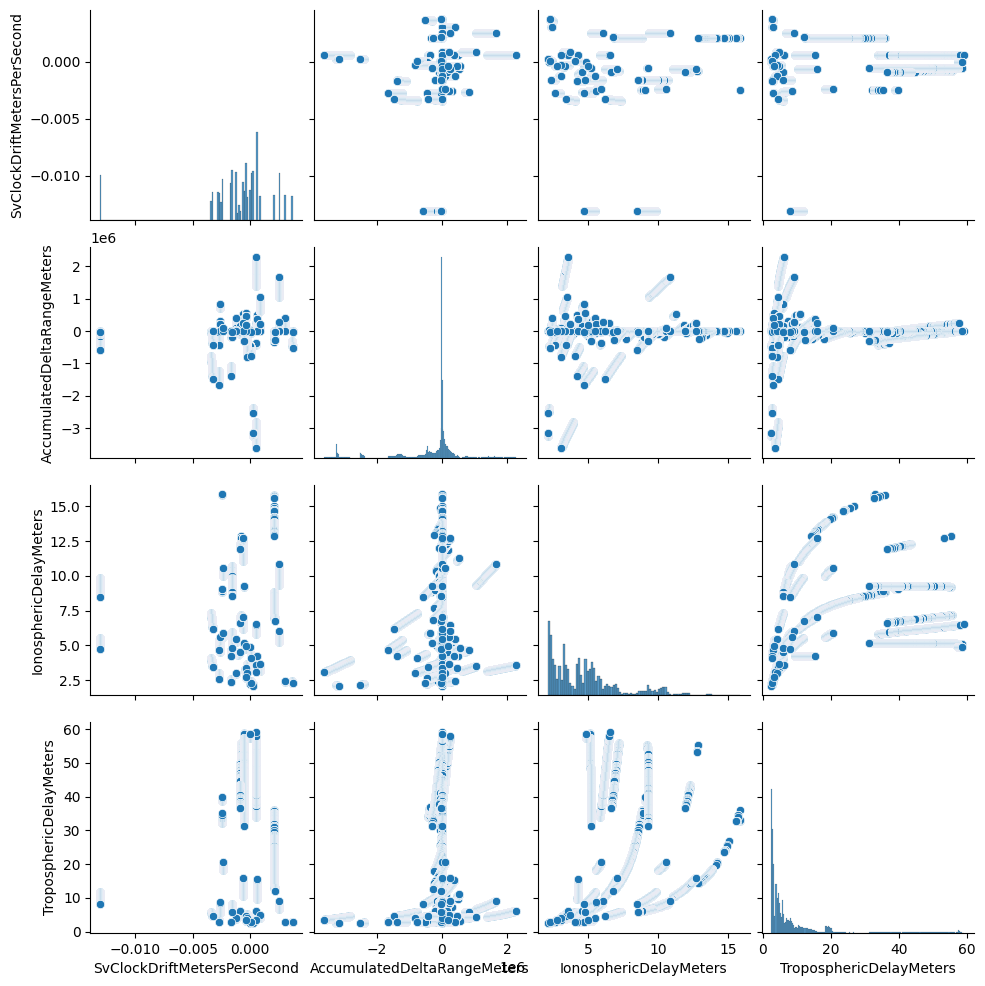

In [5]:
import seaborn as sns
sns.pairplot(df_sample_trail_gnss[["SvClockDriftMetersPerSecond", "AccumulatedDeltaRangeMeters",
                                  "IonosphericDelayMeters", "TroposphericDelayMeters"]])

It looks like there are some interesting relationships between the Ionospheric delay and the Tropospheric delay.　　電離層遅延と対流圏遅延には興味深い関係があるようだ。

One challenge we will face throughout this competition is the fact that a lot of the data is redundant. Likely only a few columns will contribute to the majority of the accuracy of our model. Let's drop the NaN data first:

このコンペティションを通じて直面する課題のひとつは、データの多くが冗長であるという事実である。モデルの精度の大部分に貢献するのは、おそらく数列だけだろう。まずはNaNデータを削除してみよう：

In [6]:
df_sample_trail_gnss.isna().sum()

MessageType                                      0
utcTimeMillis                                    0
TimeNanos                                        0
LeapSecond                                       0
TimeUncertaintyNanos                         46628
FullBiasNanos                                    0
BiasNanos                                        0
BiasUncertaintyNanos                             0
DriftNanosPerSecond                              0
DriftUncertaintyNanosPerSecond                   0
HardwareClockDiscontinuityCount                  0
Svid                                             0
TimeOffsetNanos                                  0
State                                            0
ReceivedSvTimeNanos                              0
ReceivedSvTimeUncertaintyNanos                   0
Cn0DbHz                                          0
PseudorangeRateMetersPerSecond                   0
PseudorangeRateUncertaintyMetersPerSecond        0
AccumulatedDeltaRangeState     

We can be comfortable dropping all the data that's completely missing, but the mostly complete data looks relatively important. We can use [imputation techniques](https://www.kaggle.com/code/azminetoushikwasi/all-imputation-techniques-with-pros-and-cons) to best fill in the missing data with synthetic data.

完全に欠損しているデータはすべて削除しても構わないが、ほぼ完全なデータは比較的重要である。我々は[imputation techniques](https://www.kaggle.com/code/azminetoushikwasi/all-imputation-techniques-with-pros-and-cons)を使って、欠損データを合成データで最適に埋めることができる。

Now let's take a look at our data at time-of-inference.
では、推論時点のデータを見てみよう。

In [7]:
df_test_trail_gnss = pd.read_csv(INPUT_PATH + "test/2020-12-11-19-30-us-ca-mtv-e/pixel4xl/device_gnss.csv")

In [8]:
df_test_trail_gnss

,MessageType,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,...,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,Raw,1607715055442,74585173000000,18,NaN,-1291675688269432104,-0.766369,22.548105,230.194956,9.674811,...,-340.093293,-3183.605736,238953.664854,-0.000900,0.000000,3.359449,3.872354,-2.710175e+06,-4.278810e+06,3.863761e+06
1,Raw,1607715055442,74585173000000,18,NaN,-1291675688269432104,-0.766369,22.548105,230.194956,9.674811,...,-2609.046389,-1041.838400,-8170.672094,-0.003174,0.000000,2.412421,2.769697,-2.710175e+06,-4.278810e+06,3.863761e+06
2,Raw,1607715055442,74585173000000,18,NaN,-1291675688269432104,-0.766369,22.548105,230.194956,9.674811,...,-948.201121,2096.337128,-48995.470518,-0.000954,0.000000,3.041131,3.626980,-2.710175e+06,-4.278810e+06,3.863761e+06
3,Raw,1607715055442,74585173000000,18,NaN,-1291675688269432104,-0.766369,22.548105,230.194956,9.674811,...,-616.523320,3010.480790,-90005.243128,-0.001351,0.000000,5.619127,15.589435,-2.710175e+06,-4.278810e+06,3.863761e+06
4,Raw,1607715055442,74585173000000,18,NaN,-1291675688269432104,-0.766369,22.548105,230.194956,9.674811,...,-936.390309,3013.610651,-74629.512567,-0.002282,0.000000,6.382237,10.248850,-2.710175e+06,-4.278810e+06,3.863761e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44496,Raw,1607716244442,75774173000000,18,NaN,-1291675688269331621,-0.617079,23.378161,30.537678,10.640611,...,-1383.494232,1501.608463,45131.376281,0.002822,-2348.710282,5.990558,3.918799,-2.710175e+06,-4.278810e+06,3.863764e+06
44497,Raw,1607716244442,75774173000000,18,NaN,-1291675688269331621,-0.617079,23.378161,30.537678,10.640611,...,-831.885875,2852.078260,-190890.929489,-0.000656,-2348.710282,9.256559,6.253464,-2.710175e+06,-4.278810e+06,3.863764e+06
44498,Raw,1607716244442,75774173000000,18,NaN,-1291675688269331621,-0.617079,23.378161,30.537678,10.640611,...,586.538027,-2349.088068,717663.902645,-0.013186,-2348.710282,14.045519,21.009099,-2.710175e+06,-4.278810e+06,3.863764e+06
44499,Raw,1607716244442,75774173000000,18,NaN,-1291675688269331621,-0.617079,23.378161,30.537678,10.640611,...,1028.691586,2770.533082,22291.957131,-0.002417,-2348.710282,5.698250,3.430210,-2.710175e+06,-4.278810e+06,3.863764e+06
